In [2]:
%%html
<style>
    /* Use a nicer font for the markdown preview */
    body {
        --vscode-font-family: "Baskerville"
    }
</style>

In [3]:
#| default_exp emd
from nbdev.showdoc import *
from fastcore.all import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import diffusion_curvature
from diffusion_curvature.core import *
from diffusion_curvature.datasets import *
from diffusion_curvature.gaussian_invariance import *
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2

In [4]:
""" Implements convolutional sinkhorn distances from Solomon et al. 2015
"""
import numpy as np
import pygsp
def conv_sinkhorn(
    W, m_0, m_1, stopThr=1e-4, max_iter=1e3, method="chebyshev", t=50, verbose=False
):
    """ Implements the convolutional sinkhorn operator described in Solomon et
    al. 2015. This is sinkhorn except the cost matrix is replaced with the heat
    operator which may be easier to apply.

    Notes: It is unclear how to pick t from the manuscript. We will pick by
    cross validation.

    Parameters
    ----------
    W, n x n adjacency matrix of a graph
    m_0, m_1 distributions over W numpy arrays of length n
    """
    eps = 1e-8
    N = W.shape[0]
    G = pygsp.graphs.Graph(W)
    if method == "chebyshev":
        G.estimate_lmax()
    elif method == "exact":
        G.compute_fourier_basis()
    else:
        raise NotImplementedError("Unknown method %s" % method)
    heat_filter = pygsp.filters.Heat(G, t)
    v = np.ones(N)
    w = np.ones(N)
    for i in range(1, int(max_iter) + 1):
        v_prev = v
        v = m_0 / (heat_filter.filter(w, method=method) + eps)
        w = m_1 / (heat_filter.filter(v, method=method) + eps)
        if i % 100 == 0:
            if verbose:
                print(i, np.sum(np.abs(v - v_prev)))
            if np.sum(np.abs(v - v_prev)) < stopThr:
                if verbose:
                    print("converged at iteration %d" % i)
                break

    return -np.sum(t * (m_0 * np.log(v + eps) + m_1 * np.log(w + eps)))

In [5]:
def combine_distributions(*dists):
    """Given any number of arrays, each representing separate nonoverlapping distributions over some space X, combines them into a single distribution over X"""
    dists = [d/(np.sum(d) + 1e-7) for d in dists] # normalize each to sum to one
    dists = [i + d for i,d in enumerate(dists)]
    combined_dist = sum(dists)
    return combined_dist

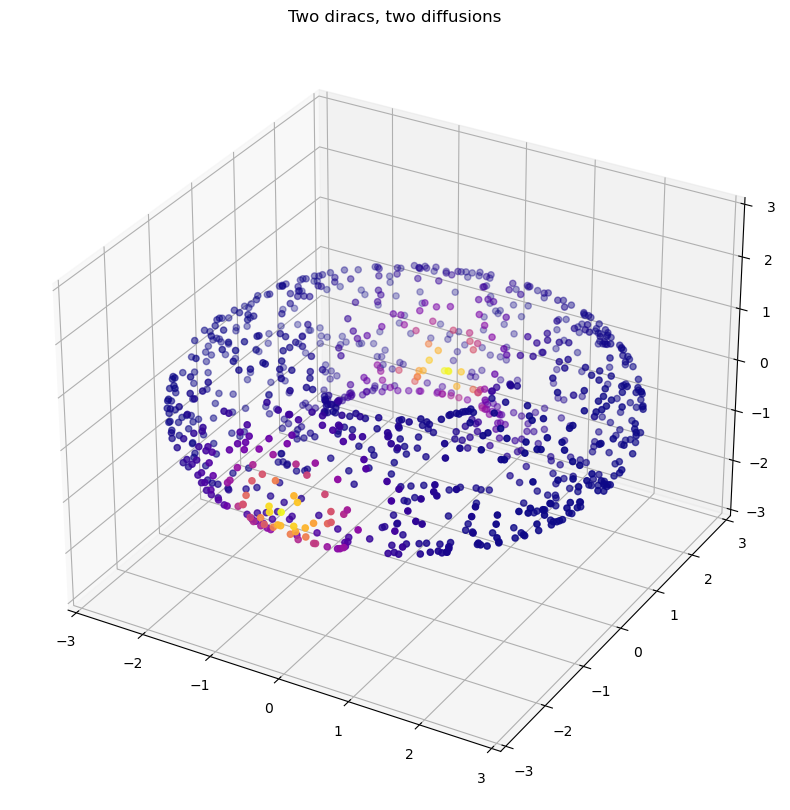

In [6]:
# set up test distributions on torus
X, ks = torus(use_guide_points=True)
A = gaussian_kernel(X, kernel_type="fixed", sigma = 0.5)
np.fill_diagonal(A,0)
P = diffusion_matrix(X,kernel_type="fixed", sigma = 0.5)
Pt = np.linalg.matrix_power(P,4)
Ptt = np.linalg.matrix_power(Pt,4)
pt1, pt2 = 0, 1
d1, d2 = P[pt1], P[pt2]
dist1, dist2 = Pt[pt1], Pt[pt2]
superdiffused1, superdiffused2 = Ptt[pt1], Ptt[pt2]
cdist = combine_distributions(d1,d2,dist1,dist2)
plot_3d(X, cdist, title = "Two diracs, two diffusions")

# Testing the distances from Convolutional Sinkhorn
Here's our first test of the diffusion-based distances. We have a dirac, its diffusion, and its "super"-diffusion. The distances should increase from diffusion to super-diffusion. 

In [91]:
conv_sinkhorn(A, d1, d1, method="exact")

71.03623604871578

In [92]:
conv_sinkhorn(A, dist1, d1, method="exact")

134.80169612484468

In [93]:
conv_sinkhorn(A, superdiffused1, d1, method="exact")

182.93519262912287

Two oddities jump out: 
1. The "distances" are negative by default. I had to add a sign to the return to correct that.
2. The distance from a point to itself is not zero, nor even the distance from a diffusion to itself. Indeed, the distance from a diffusion to itself is *greater* than the distance from the point to that diffusion.

This gives me serious doubts that I can trust this method.

In [94]:
conv_sinkhorn(A, dist1, dist1, method="exact")

198.7741513088918

In [95]:
conv_sinkhorn(A, superdiffused1, superdiffused1, method="exact")

299.07364752901236

Does the triangle inequality approximately hold?

In [96]:
a = conv_sinkhorn(A, d1, dist1)
b = conv_sinkhorn(A, dist1, superdiffused1)
c = conv_sinkhorn(A, d1, superdiffused1)
print("a+b", a+b)
print("c", c)
if a+b > c: print("Triangle ineq holds") 
else: print("Triangle inequality fails")

a+b 382.8702887417616
c 183.11182772536966
Triangle ineq holds


# Curvature

## The Wasserstein Spread of Diffusion
This measures how "spread out" our diffusion is, and provides a proxy for curvature.

In [8]:
def wasserstein_spread_of_diffusion(idx:int, A:np.ndarray, P:np.ndarray, t:int):
    dirac = np.zeros(len(P))
    dirac[idx] = 1
    P_t = np.linalg.matrix_power(P,t)
    diffused_dirac = P_t[idx]
    return conv_sinkhorn(A, dirac,diffused_dirac)

In [12]:
from functools import partial
def wasserstein_spread_of_diffusion_of_data(
        X:np.ndarray, # data points, in shape n x d
        t:int=8, # time steps of diffusion
        k:int=10, # number of neighbors to use in calculating kernel
        **kwargs
        )->np.ndarray:
    A = gaussian_kernel(X, kernel_type="adaptive",k=k)
    np.fill_diagonal(A,0)
    P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
    wsd_of_point = partial(wasserstein_spread_of_diffusion,A=A,P=P,t=t)
    entropies = parallel(wsd_of_point,np.arange(len(P)),n_workers=5,progress=True)
    return np.array(entropies) 

In [99]:
wdcs = wasserstein_spread_of_diffusion_of_data(X)

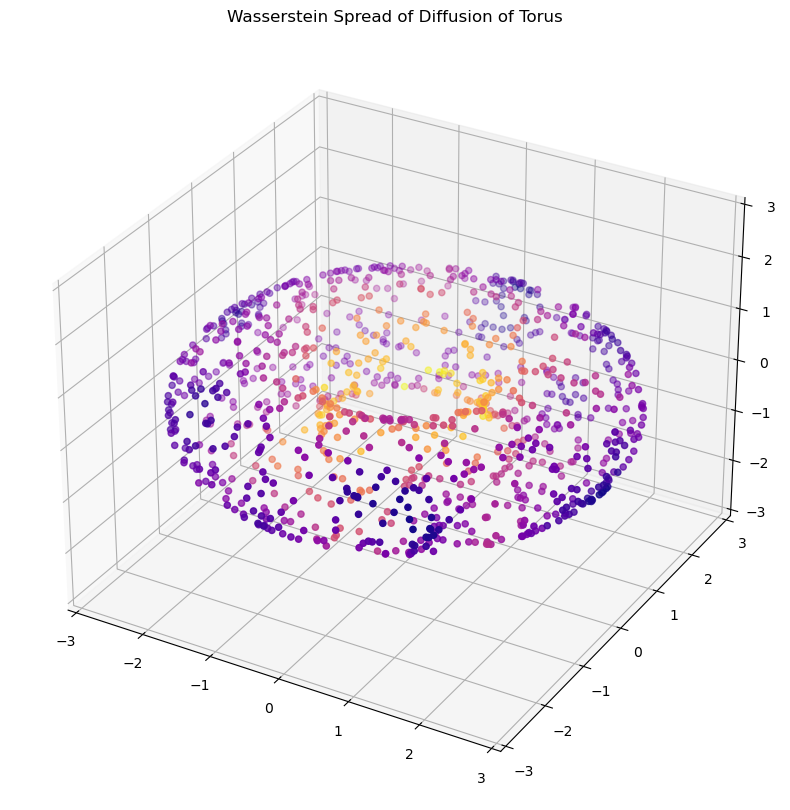

In [100]:
plot_3d(X,wdcs, title="Wasserstein Spread of Diffusion of Torus")

We now use Def 4.8:
Let $(X,d,m)$ be a metric space. The t-step Wasserstein Diffusion Curvature of a point $x \in X$ is
$$
k_{dw} = 1 - \frac{W(\delta_{x},m_{x}^t)}{tW(\delta_{x},m_{x})}
$$

In [13]:
def wasserstein_diffusion_curvature(
        X, # points
        t=8, # num diffusion steps
        k=10, # nearest neighbor to use
):
    spreads_at_t = wasserstein_spread_of_diffusion_of_data(X, t=t, k = k)
    spreads_at_1 = wasserstein_spread_of_diffusion_of_data(X, t=1, k = k)
    ration = spreads_at_t / (t*spreads_at_1)
    return 1 - ration

In [20]:
wks = wasserstein_diffusion_curvature(X, t=8, k=10)

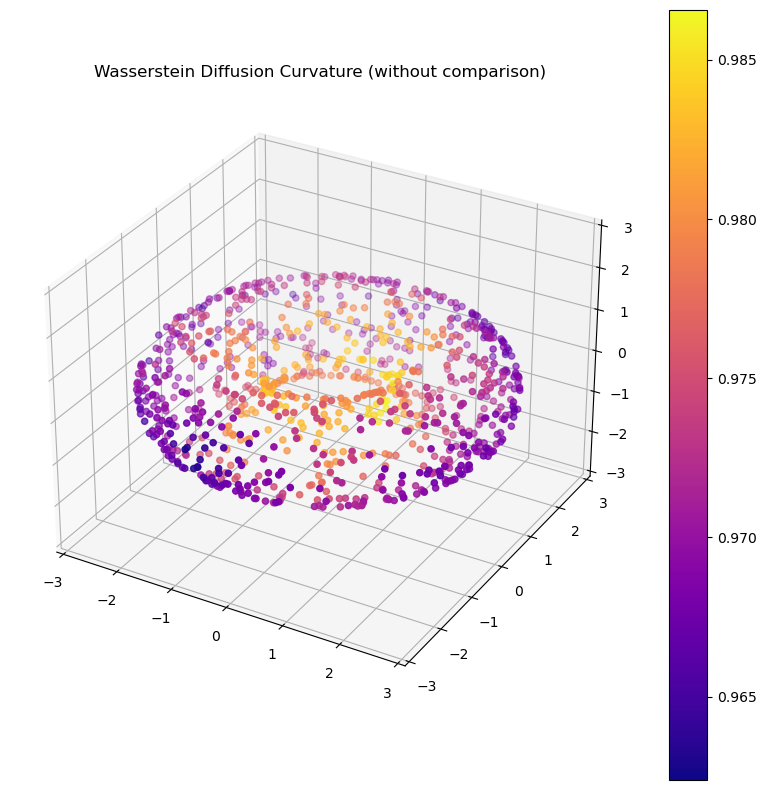

In [21]:
plot_3d(X, wks, colorbar=True,title="Wasserstein Diffusion Curvature (without comparison)")

In [39]:
def wasserstein_diffusion_comparison_curvature(
        X, # points
        dim, # dimension of X
        t=8, # num diffusion steps
        k=10, # nearest neighbor to use
):
    # compute spread of diffusion of center point of plane
    nd_plane = np.concatenate([np.zeros((1,dim)), np.random.rand(len(X),dim)])
    A_plane = gaussian_kernel(nd_plane, kernel_type="adaptive",k=k)
    np.fill_diagonal(A_plane,0)
    P_plane = compute_anisotropic_diffusion_matrix_from_graph(A_plane, alpha=1)
    spreads_on_plane = wasserstein_spread_of_diffusion(idx=0,A = A_plane,P = P_plane,t=t)
    # manifold
    spreads_on_manifold = wasserstein_spread_of_diffusion_of_data(X, t=t, k = k)
    ration = spreads_on_manifold / (spreads_on_plane)
    return 1 - ration

In [40]:
wks_comp = wasserstein_diffusion_comparison_curvature(X,dim=2)

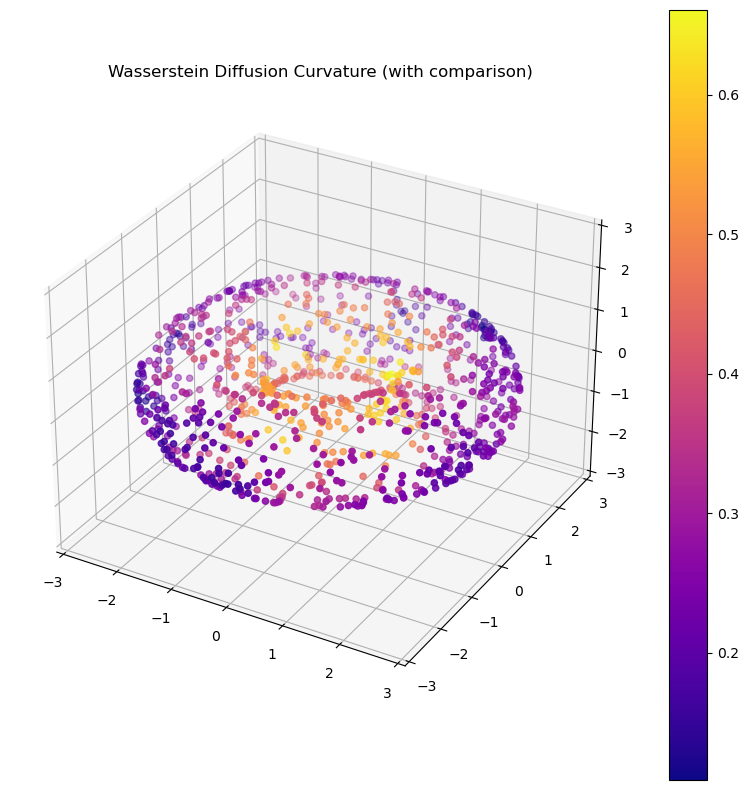

In [41]:
plot_3d(X, wks_comp, colorbar=True,title="Wasserstein Diffusion Curvature (with comparison)")